# Yelp Rating Classification

My goal for this project was to create a tool for businesses using Yelp data that would show a business how their Yelp rating could change by adjusting certain Yelp-specific levers (i.e. number of check-ins, number of tips, number of photos, etc). This requires using a classification algorithm that supplies interpretable results, which is why I chose Logistic Regression. Using Logistic Regression, the tool can show a business how the probability of having each rating changes as a single attribute changes, while holding all other attributes constant. 

In [35]:
import pandas as pd
import pickle
from sklearn.cross_validation import train_test_split
import statsmodels as sm
import numpy as np
from sklearn import metrics
from scipy.optimize import minimize
import scipy.stats
from tqdm import tqdm
import pprint
from patsy import dmatrices, dmatrix
from scipy.stats import t
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

### Helper Functions
Below are a series of function to perform 1) multi-class ordered logistic regression and 2) normal multi-class logistic regression. These functions were created by a combination of a teacher at Metis and myself. 

In [36]:
### Ordered Logit ###

def ordered_probit_mle(b,X,y):
    """A function to compute the ordered probit log-likelihood."""
    X = np.array(X)
    y = np.array(y)
    xb = X.dot(b[0:(X.shape[1])])    #compute xb
    mu = [float('-inf'),0]    #initialize the list of mus
    for i in range(len(b[X.shape[1]:])):    #loop over categories
        mu = mu + [mu[i+1] + np.exp(b[X.shape[1]:][i])]    #and create each mu
    mu = mu + [float('inf')]    #append infinity on the end
    probs = np.zeros(len(y))    #set up an array of 0s
    for i in range(1,len(set(y)) + 1):    #loop over categories
        probs = probs + (scipy.stats.norm.cdf(mu[i] - xb) - scipy.stats.norm.cdf(mu[i - 1] - xb))*(y == list(set(y))[i-1]) 
    probs[np.where(probs < 1e-100)[0]] = 1e-100
    return -1*sum(np.log(probs))

def OP_predicted_values(b,X):
    """A function to compute predicted values in the ordered probit."""
    X = np.array(X)
    xb = X.dot(b[0:(X.shape[1])])    #compute xb
    mu = [float('-inf'),0]    #initialize the list of mus
    for i in range(len(b[X.shape[1]:])):    #loop over categories
        mu = mu + [mu[i+1] + np.exp(b[X.shape[1]:][i])]    #and create each mu
    mu = mu + [float('inf')]    #append infinity on the end
    y_pred = np.zeros(len(xb))    #set up an array of zeros
    for i in range(1,len(mu)):    #loop over categories
        y_pred = y_pred + (((mu[i-1]<xb)*1*(mu[i]>xb)*1)*(i-1))    #check which category each falls in
    return y_pred

def ordered_logit_effects(b,X,which_variable,num_x):
    """A function to compute the predicted probability as x varies"""
    beta = b[:X.shape[1]]
    X = np.array(X)
    x_mean = np.mean(X,0)    #compute the means
    mu = [float('-inf'),0]    #initialize the list of mus
    for i in range(len(b[X.shape[1]:])):    #loop over categories
        mu = mu + [mu[i+1] + np.exp(b[X.shape[1]:][i])]    #and create each mu
    mu = mu + [float('inf')]    #append infinity on the end
    grid = np.linspace(0,max(X[:,which_variable]) / 3.0,num_x)    #make a grid
    probs = []    #a list to hold the predicted probabilities
    for g in grid:    #loop over grid
        x_mean[which_variable] = g    #replace
        xb = x_mean * beta
        probs_list = []     # probability of each category, given g/x
        for i in range(1,len(set(y)) + 1):    #loop over categories
            probs_list.append((scipy.stats.norm.cdf(mu[i] - xb) - scipy.stats.norm.cdf(mu[i - 1] - xb)))    #compute probability
        probs.append(np.array(probs_list).mean(axis=1))
    return probs, grid

def bootstrap_ordered_logit(X_train, y_train, X_test, n_boot=1000):
    coefficients = []
    predictions = []
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    
    for _ in tqdm(range(n_boot)):
        boot = np.random.randint(0, len(y_train)-1, len(y_train))
        y_boot = y_train[boot]
        X_boot = X_train[boot]
        
        # Get starting betas from OLS
        ols = LinearRegression()
        ols.fit(X_boot, y_boot)
        betas = ols.coef_

        # Run Ordinal Logit Regression model
        N = len(y_boot)
        b = list(betas) + list(np.random.uniform(0,1.0,len(set(y_boot))-2))
        model_nm = minimize(ordered_probit_mle, x0 = b, args = (X_boot, y_boot), 
                            method = 'Nelder-Mead', options={'maxiter': 3000})
        cs = model_nm.x
        coefficients.append(cs)
        
        # Predict classes
        y_pred = OP_predicted_values(cs, X_test)
        predictions.append(y_pred)
    
    return [np.mean(np.array(coefficients), 0),
            np.std(np.array(coefficients), 0),
            np.percentile(np.array(coefficients), 2.5, 0),
            np.percentile(np.array(coefficients), 97.5, 0),
            scipy.stats.mstats.mode(predictions, 0)[0][0].data]


### Normal Logit ###

def logit_effects(b, intercept, X, num_x, which_variable, category, city, cutoff):
    """A function to compute the predicted probability as x varies"""
    x_mean = np.mean(X,0)    #compute the means
    x_mean[cutoff:] = 0
    x_mean[category] = 1.0
    x_mean[city] = 1.0
    grid = np.linspace(0,np.percentile(X[which_variable],97.5),num_x)    #make a grid
    probs = []    #a list to hold the predicted probabilities
    
    for g in grid:    #loop over grid
        x_mean[which_variable] = g    #replace
        xb_total = 0
        for i in range(3):
            xb_total += np.exp(intercept[i] + x_mean.dot(b[i]))
        prob_list = []
        for i in range(3):
            prob_list.append(np.exp(intercept[i] + x_mean.dot(b[i]))/(1 + xb_total))    #compute the logit transform
        prob_list.append(1 / (1 + xb_total))
        probs.append(prob_list)
    return probs, grid

def logit_effects_sample(b, intercept, business_X, total_X, num_g, which_variable):
    """A function to compute the predicted probability as x varies for a particular business"""
    x_mean = np.mean(business_X,0)    #compute the means
    grid = np.linspace(0,np.percentile(total_X[which_variable],97.5),num_g)    #make a grid
    probs = []    #a list to hold the predicted probabilities
    for g in grid:    #loop over grid
        x_mean[which_variable] = g    #replace
        xb_total = 0
        for i in range(3):
            xb_total += np.exp(intercept[i] + x_mean.dot(b[i]))
        prob_list = []
        for i in range(3):
            prob_list.append(np.exp(intercept[i] + x_mean.dot(b[i]))/(1 + xb_total))    #compute the logit transform
        prob_list.append(1 / (1 + xb_total))
        probs.append(prob_list)
    return probs, grid

def logit_effects_bin(b, intercept, business_X, total_X, num_g, which_variable):
    """A function to compute the predicted probability as x varies"""
    x_mean = np.mean(business_X,0)    #compute the means
    grid = np.linspace(0,np.percentile(total_X[which_variable],97.5),num_g)    #make a grid
    probs = []    #a list to hold the predicted probabilities
    for g in grid:    #loop over grid
        x_mean[which_variable] = g    #replace
        probs.append((np.exp(intercept + x_mean.dot(b))/(1 + np.exp(intercept + x_mean.dot(b))))[0])    #compute the logit transform
    return probs, grid

def bootstrap_logit(X_train, y_train, X_test, n_boot=1000):
    coefficients = []
    intercepts = []
    predictions = []
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    
    for _ in tqdm(range(n_boot)):
        boot = np.random.randint(0, len(y_train)-1, len(y_train))
        y_boot = y_train[boot]
        X_boot = X_train[boot]
        
        lr = LogisticRegression()
        lr.fit(X_boot, y_boot)
        coefficients.append(lr.coef_)
        intercepts.append(lr.intercept_)
        
        # Predict classes
        y_pred = lr.predict(X_test)
        predictions.append(y_pred)
    
    return [np.mean(np.array(coefficients), 0),
            np.mean(np.array(intercepts), 0),
            np.std(np.array(coefficients), 0),
            np.percentile(np.array(coefficients), 2.5, 0),
            np.percentile(np.array(coefficients), 97.5, 0),
            scipy.stats.mstats.mode(predictions, 0)[0][0].data]

# Logistic Regression

Load the dataframe containing labels and features that was produced in the file **yelp_data_exploration.ipynb**

In [37]:
with open('pickle/total_clean_github.pickle', 'rb') as handle:
    df = pickle.load(handle)

In [38]:
df.head()

,business_id,name,category_main,city,state,latitude,longitude,review_count,stars,num_checkins,...,votes.funny,votes.useful,total_votes,user_avg_num_compliments,user_num_elite,user_avg_num_friends,user_avg_review_count,user_avg_num_fans,num_photos,stars_int
0,5UmKMjUEUNdYWqANhGckJw,Mr Hoagie,Restaurants,"Pittsburgh, PA",PA,40.354327,-79.900706,4,4.5,0.0,...,0.0,0.0,0.0,4.0,0.0,1.0,24.0,0.0,1.0,4
1,UsFtqoBl7naz8AVUBZMjQQ,Clancy's Pub,Nightlife,"Pittsburgh, PA",PA,40.350553,-79.886814,4,3.5,0.0,...,0.0,0.0,0.0,27.0,1.0,10.0,60.0,2.0,0.0,3
3,cE27W9VPgO88Qxe4ol6y_g,Cool Springs Golf Center,Active Life,"Pittsburgh, PA",PA,40.354116,-80.014660,5,2.5,9.0,...,0.0,2.0,2.0,13.0,1.0,6.0,46.0,1.0,0.0,2
4,HZdLhv6COCleJMo7nPl-RA,Verizon,Shopping,"Pittsburgh, PA",PA,40.357620,-80.059980,5,2.5,0.0,...,5.0,9.0,23.0,527.0,1.0,181.0,185.0,9.0,0.0,2
7,KayYbHCt-RkbGcPdGOThNg,Alexion's Bar & Grill,Restaurants,"Pittsburgh, PA",PA,40.415517,-80.067534,21,4.0,55.0,...,4.0,7.0,15.0,122.0,0.0,11.0,66.0,4.0,0.0,4


Taking a look at the size of each class, it may be best to employ over- and under-sampling to even out the class imbalance

In [39]:
stars = df.groupby(by='stars_int')
stars.size()

stars_int
1     2167
2     9269
3    24402
4    27136
dtype: int64

First, split the data into a train and test set so that our test data does not end up in the sample

In [41]:
mask = np.random.rand(df.shape[0]) < 0.7
train = df[mask]
test = df[~mask]

Now create even samples from the training data

In [42]:
sample1 = train[train.stars_int == 1].sample(5000, replace=True)
sample2 = train[train.stars_int == 2].sample(5000, replace=True)
sample3 = train[train.stars_int == 3].sample(5000, replace=True)
sample4 = train[train.stars_int == 4].sample(5000, replace=True)
sample = sample1.append(sample2).append(sample3).append(sample4)

print 'There are %d items in this sample' % len(sample)

There are 20000 items in this sample


In [43]:
stars_sample = sample.groupby(by='stars_int')
stars_sample.size()

stars_int
1    5000
2    5000
3    5000
4    5000
dtype: int64

In [44]:
sample.head()

,business_id,name,category_main,city,state,latitude,longitude,review_count,stars,num_checkins,...,votes.funny,votes.useful,total_votes,user_avg_num_compliments,user_num_elite,user_avg_num_friends,user_avg_review_count,user_avg_num_fans,num_photos,stars_int
8995,qeOrjo2GlITleeZiW8y-fw,KFC,Restaurants,"Las Vegas, NV",NV,36.145100,-115.137000,13,1.5,23.0,...,4.0,1.0,7.0,103.0,0.0,12.0,34.0,1.0,2.0,1
12343,0NeDVUK7wtKDZ3OvgB0I9A,Sam's Club,Shopping,"Madison, WI",WI,43.051154,-89.505472,5,1.5,60.0,...,1.0,10.0,15.0,16.0,1.0,6.0,135.0,2.0,0.0,1
67320,k6HW-HxR9DkajC-4nLPhCQ,Royal Cab,Hotels & Travel,"Charlotte, NC",NC,35.242507,-80.822494,4,1.5,0.0,...,0.0,11.0,11.0,23.0,1.0,11.0,47.0,2.0,0.0,1
39298,3CLSpUACaPywC58Dphpf8Q,Gnc,Shopping,"Phoenix, AZ",AZ,33.276754,-111.786914,7,1.5,10.0,...,1.0,8.0,9.0,1.0,0.0,4.0,24.0,0.0,0.0,1
14843,ZCHPwh2qjsrm_TOwTvY-wQ,Ekmark & Ekmark,Professional Services,"Phoenix, AZ",AZ,33.534254,-111.927419,6,1.0,0.0,...,13.0,11.0,25.0,4.0,0.0,6.0,27.0,0.0,0.0,1


## Feature Selection

Since the ultimate goal is to create a tool that helps a business improve their ratings, I chose only the features that I felt a business could somewhat control. Even if a business cannot directly control all of these features, they can incentivize customers in creative ways to help improve these metrics and, hence, their business. 

In [45]:
indep_vars = ['review_count',
              'num_tips',
              'avg_time_btw_reviews',
              'avg_review_length',
              'user_num_elite',
              'num_checkins',
              'num_photos']

### Logistic Regression

Split the data into a training and testing set

In [46]:
X_train = sample[indep_vars]
y_train = sample['stars_int']

X_test = test[indep_vars]
y_test = test['stars_int']

Run an **Ordered Logit Model** using a bootstrap approach so that we can extract the confidence intervals of the coefficients, which will help us determine which independent variables are significant. <br/>
The Ordered Logit model is able to take advantage of the ordinal nature of the dependent variable - Yelp ratings. 

In [47]:
coeff_ordered, se_ordered, ci_low_ordered, ci_hi_ordered, preds_ordered = bootstrap_ordered_logit(X_train, y_train, X_test, n_boot=100)

100%|██████████| 100/100 [1:09:19<00:00, 41.20s/it]


Find the accuracy / percent correctly predicted

In [48]:
percent_correct_ordered = sum((preds_ordered.astype(int) - y_test.values)==0)/float(len(y_test))*100
print 'Percent correctly predicted is: %.1f' % percent_correct_ordered

Percent correctly predicted is: 5.6


Run a **Logit Model** using a bootstrap approach. <br/>
I want to test if the Ordered Logit model is in fact giving better results.

In [49]:
coeff, inter, se, ci_low, ci_hi, preds = bootstrap_logit(X_train, y_train, X_test, n_boot=100)

100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Find the accuracy

In [51]:
percent_correct = sum((preds.astype(int) - y_test.values)==0)/float(len(y_test))*100
print 'Percent correctly predicted is: %.1f' % percent_correct

Percent correctly predicted is: 31.3


Given the higher accuracy for the normal Logit Model, we will continue using this model's information.

### Look at the Results

Let's take a look at each of the feature's coefficients. Each feature has 4 coefficients - one for each class. Here is the coefficients for the first class - 1 star. These coefficients tell us that as a business' review count and average review length increases, the probability of having 1 star increases. This makes some logical sense - as reviews get longer, it may be an indication of a customer who felt strong about the business in a negative way; however, the review count makes less sense. The coefficients also tell us that as a business' number of tips, average time between reviews, number of elite reviewers, number of checkins, and number of photos increases, the probability of having 1 star decreases. This also makes sense as having more of all of these would seem to indicate a healthy, well-liked business. 

In [53]:
zip(coeff[0], indep_vars)

[(0.022829011893223162, 'review_count'),
 (-0.017667887768894133, 'num_tips'),
 (-0.00021310985169748924, 'avg_time_btw_reviews'),
 (0.0010201410896751432, 'avg_review_length'),
 (-0.27280124703899961, 'user_num_elite'),
 (-0.0038371422400684356, 'num_checkins'),
 (-0.29383956271182315, 'num_photos')]

And here are the coefficients for all 4 classes for the last feature - number of photos. Here we can see that the beta for the number of photos feature goes from negative to positive as the number of stars increases. This means that as the number of photos increases, the model predicts that the probability of having 1, 2, or 3 stars decreases while the probability of having 4 stars increases, which would be expected.

In [70]:
zip(coeff[:,6], ['1 star', '2 stars', '3 stars', '4 stars'])

[(-0.29383956271182315, '1 star'),
 (-0.061014674991657067, '2 stars'),
 (-0.01485980974722886, '3 stars'),
 (0.082431978779361703, '4 stars')]

Here are the confidence intervals for the coefficients of each feature for the first class - 1 star. As none of the confidence intervals include 0, we can conclude that all of the features are significant in the 1 star class case.

In [58]:
zip(ci_low[0], ci_hi[0], indep_vars)

[(0.01848772950920595, 0.027232243735341687, 'review_count'),
 (-0.036672069021609494, -0.0026833103079233504, 'num_tips'),
 (-0.00042893392963914967, -6.6170188141290008e-05, 'avg_time_btw_reviews'),
 (0.00092058837670445362, 0.0011255825105746871, 'avg_review_length'),
 (-0.3108250721663286, -0.232869944833756, 'user_num_elite'),
 (-0.0067159912116060974, -0.0015492068300922411, 'num_checkins'),
 (-0.33996626750940712, -0.25557747735371933, 'num_photos')]

And here are the confidence intervals for the coefficients of all 4 classes for the first feature - review count. The confidence interval for the 1, 2, and 4 star case all include 0, meaning that this feature is not significant in these classes. 

In [71]:
zip(ci_low[:,6], ci_hi[:,0], ['1 star', '2 stars', '3 stars', '4 stars'])

[(-0.33996626750940712, 0.027232243735341687, '1 star'),
 (-0.090750173728495406, 0.001984253270689954, '2 stars'),
 (-0.025566638647882865, -0.00077982762453366055, '3 stars'),
 (0.064483782338890377, -0.00076007649709290183, '4 stars')]

## Visualize the Results

### Probability Charts
As mentioned above, the goal is to see how the probability of having a particular Yelp rating changes as one independent variable changes, holding all else constant. Below is code that create this chart.

First, sample an individual business from the data to use this business' features. Here we have an Automotive company in Charlotte, NC.

In [92]:
business_features = X_test.sample(1)
df[df.index == business_features.index[0]]

,business_id,name,category_main,city,state,latitude,longitude,review_count,stars,num_checkins,...,votes.funny,votes.useful,total_votes,user_avg_num_compliments,user_num_elite,user_avg_num_friends,user_avg_review_count,user_avg_num_fans,num_photos,stars_int
59720,MEKsLIEtRakbGtup1jRA6A,Firestone Complete Auto Care,Automotive,"Charlotte, NC",NC,35.033108,-80.805605,6,2.0,9.0,...,2.0,7.0,10.0,157.0,0.0,18.0,114.0,4.0,1.0,2


Create an aggregated X dataframe so that each business can be compared to all businesses in the dataset

In [88]:
X = X_train.append(X_test)

Next, we plot the probability of being in each class as one feature changes, assuming all other features stay constant.

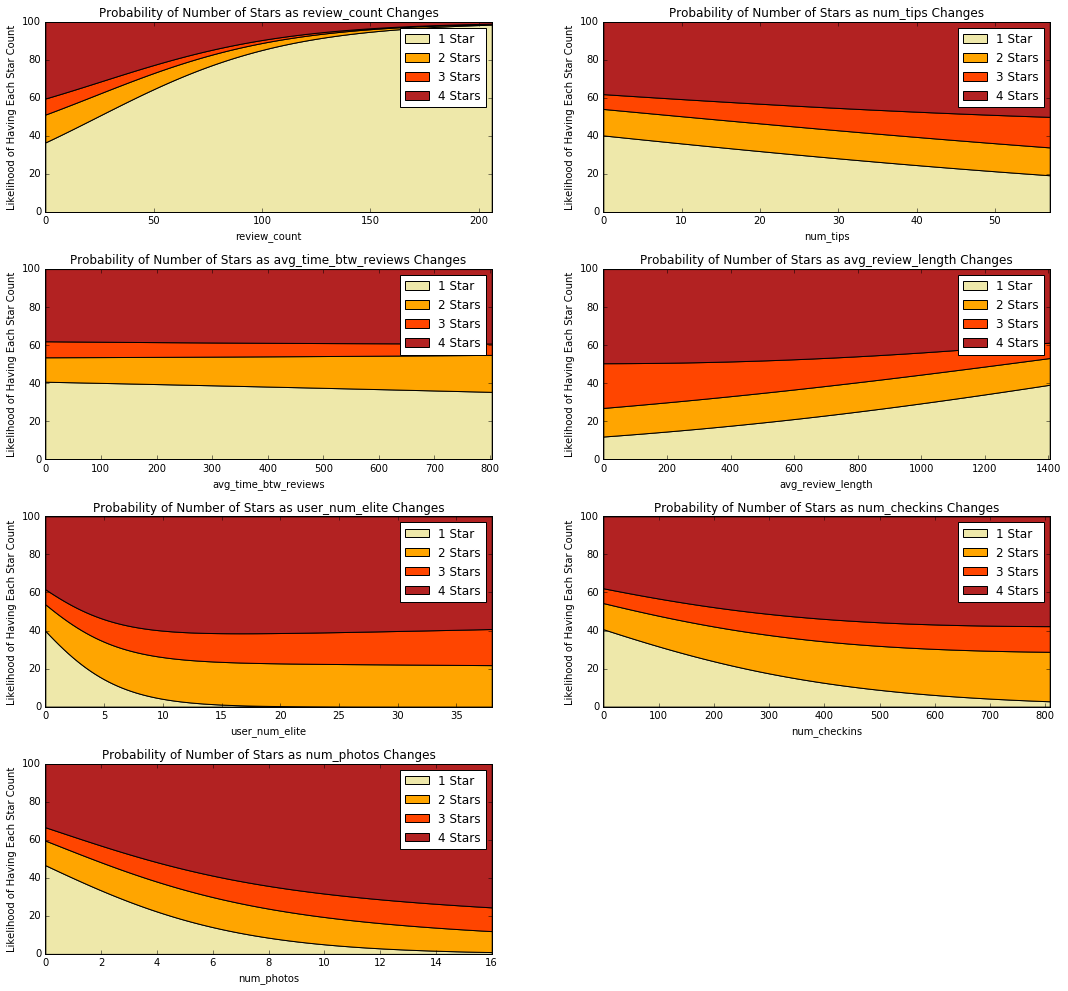

In [93]:
plt.figure(figsize=(18,30))

c = 1
for i in indep_vars:
    probs, grid = logit_effects_sample(coeff, inter, business_features, X, num_g = 100, which_variable = i)
    ys =  np.array(probs).T
    percent_ys = ys /  ys.sum(axis=0).astype(float) * 100 
    plt.subplot(7,2,c)
    plt.stackplot(grid, percent_ys, labels = ['1 Star', '2 Stars', '3 Stars', '4 Stars'],
                 colors=['palegoldenrod', 'orange', 'orangered', 'firebrick'])
    plt.xlim(0,max(grid))
    plt.ylim(0,100)
    plt.title('Probability of Number of Stars as %s Changes' % i)
    plt.xlabel(i)
    plt.ylabel('Likelihood of Having Each Star Count')
    plt.legend(loc='best')
    c += 1

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.3)

### Confusion Matrix

Below we take a look at the confusion matrix to get a better sense of the models accuracy.

In [97]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Reds):
    """Creates a confusion matrix."""
    target_names = ['1 star', '2 stars', '3 stars', '4 stars']
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 
    
    ax = plt.gca()
    pos1 = ax.get_position()
    pos2 = [pos1.x0 + 0.03, pos1.y0 + 0.1, pos1.width, pos1.height - 0.2]
    ax.set_position(pos2)
    
    plt.savefig('fig/cm')

The darker the box, the higher the percentage of correctly predicted businesses. As we can see from looking at the diagnoal, the 1 star class had the highest accuracy, followed by the 4 star class. It appears that the model was biased towards predicting either 1 or 4 stars. This phenomemon can be seen in the chart above - the 1 star and 4 star class have much higher probabilities than the 2 or 3 star classes. This would be something I could investigate further.

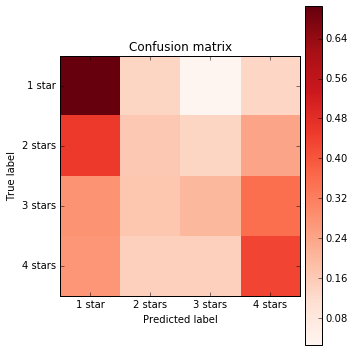

In [99]:
cm = confusion_matrix(np.array(y_test), np.array(preds))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)